In [2]:
from pypinyin import lazy_pinyin, Style
import torch

MODELS = {
    'vqvae.pth':'/home/hyc/tortoise_plus_zh/ttts/vqvae/logs/2023-11-24-01-21-25/model-30.pt',
    'gpt.pth': '/home/hyc/tortoise_plus_zh/ttts/gpt/logs/2023-11-26-22-56-38/model-29.pt',
    'clvp2.pth': '',
    'diffusion.pth': '~/tortoise_plus_zh/ttts/diffusion/logs/2023-10-27-00-00-28/model-12.pt',
    'vocoder.pth': '~/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin',
    'rlg_auto.pth': '',
    'rlg_diffuser.pth': '',
}

In [3]:
from ttts.gpt.voice_tokenizer import VoiceBpeTokenizer
import torch.nn.functional as F
device = 'cuda:1'
text = "大家好，今天来点大家想看的东西。"
# text = "霞浦县衙城镇乌旗瓦窑村水位猛涨。"
# text = '高德官方网站，拥有全面、精准的地点信息，公交驾车路线规划，特色语音导航，商家团购、优惠信息。'
# text = '先帝创业未半而中道崩殂，今天下三分，益州疲弊，此诚危急存亡之秋也。然侍卫之臣不懈于内，忠志之士忘身于外者，盖追先帝之殊遇，欲报之于陛下也。诚宜开张圣听，以光先帝遗德，恢弘志士之气，不宜妄自菲薄，引喻失义，以塞忠谏之路也。'
pinyin = ' '.join(lazy_pinyin(text, style=Style.TONE3, neutral_tone_with_five=True))
tokenizer = VoiceBpeTokenizer('gpt/gpt_tts_tokenizer.json')
text_tokens = torch.IntTensor(tokenizer.encode(pinyin)).unsqueeze(0).to(device)
text_tokens = F.pad(text_tokens, (0, 1))  # This may not be necessary.
text_tokens = text_tokens.to(device)
print(pinyin)
print(text_tokens)

da4 jia1 hao3 ， jin1 tian1 lai2 dian3 da4 jia1 xiang3 kan4 de5 dong1 xi1 。
tensor([[161,   2, 155,   2,  16,  87,   2,  43,   2, 224,   2, 171,  71,   2,
         182,   2, 188,   2, 161,   2, 155,   2,  62,  92,   2,  19,  63,   2,
          65,   2,  12,  84,   2, 228,   2,  39,   0]], device='cuda:1',
       dtype=torch.int32)


In [4]:
from ttts.utils.infer_utils import load_model
from ttts.vocoder.feature_extractors import MelSpectrogramFeatures
import torchaudio
# device = 'gpu:0'
gpt = load_model('gpt',MODELS['gpt.pth'],'gpt/config.json',device)
gpt.post_init_gpt2_config(use_deepspeed=False, kv_cache=False, half=False)
# diffusion = load_model('diffusion',MODELS['diffusion.pth'],'ttts/diffusion/config.json',device)
cond_audio = '0.wav'
audio,sr = torchaudio.load(cond_audio)
if audio.shape[0]>1:
    audio = audio[0].unsqueeze(0)
audio = torchaudio.transforms.Resample(sr,24000)(audio)
cond_mel = MelSpectrogramFeatures()(audio).to(device)
print(cond_mel.shape)

/home/hyc/miniconda3/envs/vocos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hyc/miniconda3/envs/vocos/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


torch.Size([1, 100, 413])


In [5]:
auto_conditioning = cond_mel
settings = {'temperature': .8, 'length_penalty': 1.0, 'repetition_penalty': 2.0,
                    'top_p': .8,
                    'cond_free_k': 2.0, 'diffusion_temperature': 1.0}
top_p = .8
temperature = .8
autoregressive_batch_size = 1
length_penalty = 1.0
repetition_penalty = 2.0
max_mel_tokens = 600
print(auto_conditioning.shape)
print(text_tokens.shape)
# text_tokens = F.pad(text_tokens,(0,400-text_tokens.shape[1]),value=0)
print(text_tokens.shape)
codes = gpt.inference_speech(auto_conditioning, text_tokens,
                                do_sample=True,
                                top_p=top_p,
                                temperature=temperature,
                                num_return_sequences=autoregressive_batch_size,
                                length_penalty=length_penalty,
                                repetition_penalty=repetition_penalty,
                                max_generate_length=max_mel_tokens)
print(codes)

torch.Size([1, 100, 413])
torch.Size([1, 37])
torch.Size([1, 37])
tensor([[1806, 6663, 2343, 4339, 1638,  611, 5157, 2318, 7076, 5115,  475, 4253,
         4895, 2015,  200, 3309, 6455, 4177, 2699, 1472,  398, 2496, 2829, 5092,
         3175, 4584, 1847, 4634,  170,  189, 1126, 7522, 7844, 2605, 1498, 6755,
         2617, 5277,  679,  550, 3249, 5174, 2497,  169, 7805, 3311, 1972, 1831,
         6545, 1299, 3886, 4758,  281, 2682, 6318, 6423, 3750, 3416, 1783, 6127,
         4478,  140,  998, 2153, 4666, 7699, 4865, 2537, 7399, 1581, 2222, 3499,
         8016, 1284, 5759, 5501, 2775, 5131, 4014, 3135, 3622,  346, 6547, 8193]],
       device='cuda:1')


In [6]:
vqvae = load_model('vqvae', MODELS['vqvae.pth'], 'vqvae/config.json', device)
mel = vqvae.decode(codes[:,:-1])[0]
codes_gt = vqvae.get_codebook_indices(cond_mel)
print(codes_gt)
mel.shape

tensor([[4634, 4650, 3379, 1656, 5430, 2497, 5813, 3294, 5749, 5346, 3302, 4648,
         2689,  260, 2943, 4064, 5203,  329, 2412, 7306, 7306, 6370, 4414, 3775,
         7724, 7108, 1472, 5911, 4576, 3175, 6068, 3677, 4141, 3238, 5092, 5802,
         5092, 7995, 2463, 4141, 4576, 4408, 6028, 5201, 7707, 1020, 3531,  952,
         7074, 6390, 5501, 4645, 1498, 1613,  674, 1129, 8051, 1477, 3902, 4253,
         6230,  208, 4564, 7399,  611, 4092, 1414, 5593, 6680, 7034, 6664, 6575,
         2775, 5682, 2985, 3472, 2417,  421, 6390, 2617, 3874, 6005, 3302, 3024,
          456, 5802, 5203, 7198, 2648, 6391, 3530, 7578, 5525, 2381, 1993, 8016,
         7916, 6145, 5903, 7330, 4414, 5945,  742, 7864]], device='cuda:1')


torch.Size([1, 100, 332])

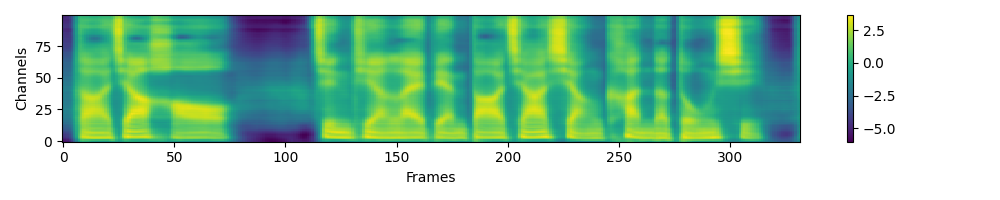

In [7]:
from PIL import Image
import numpy as np
from IPython.display import display
from ttts.utils.utils import plot_spectrogram_to_numpy
img = plot_spectrogram_to_numpy(mel[0, :, :].detach().unsqueeze(-1).cpu())
image = Image.fromarray(np.uint8(img))
display(image)

In [8]:
from ttts.vocoder.vocos import Vocos


vocos = Vocos.from_pretrained('pretrained_models/pytorch_model.bin','vocoder/config.yaml').to(device)
audio = vocos.decode(mel)
print(audio.shape)
torchaudio.save('gen.wav',audio.detach().cpu(), 24000)

torch.Size([1, 84736])


: 

In [25]:
latent = gpt(auto_conditioning, text_tokens,
    torch.tensor([text_tokens.shape[-1]], device=text_tokens.device), codes,
    torch.tensor([codes.shape[-1]*gpt.mel_length_compression], device=text_tokens.device),
    return_latent=True, clip_inputs=False)
latent.shape

torch.Size([1, 123, 1024])

In [ ]:

mel = do_spectrogram_diffusion(diffusion, diffuser, latents, diffusion_conditioning, temperature=diffusion_temperature, 
                                                    verbose=verbose)
                        wav = vocoder.inference(mel)

In [33]:
from ttts.vocoder.vocos import Vocos
from IPython.display import Audio
vocoder = Vocos.from_pretrained("~/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin","~/tortoise_plus_zh/ttts/vocoder/config.yaml")
audio = vocoder.decode(mel.cpu())
torchaudio.save('gen_0.wav',audio,24000)
Audio('gen_0.wav')